<a href="https://colab.research.google.com/github/smuratsirin/Market_Design_Lit_Review/blob/main/Topic_Modelling_LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!python -m spacy download en_core_web_lg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 587.7/587.7 MB 847.5 kB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [1]:
import pandas as pd
import spacy
import gensim
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim import corpora
from tqdm import tqdm
from gensim.models import CoherenceModel, LdaModel
import random
random.seed(42)

In [2]:
# Load data
df = pd.read_csv('/content/sample_data/wos_2009.csv', encoding = "latin1")  # Ensure the CSV has columns 'title' and 'abstract'

In [11]:
# Initialize spaCy model
nlp = spacy.load('en_core_web_lg')

# Define a list of additional stopwords to remove
additional_stopwords = {"ltd.", "right", "c.right", "copyright", "elsevier", "c", "paper"}

# Preprocess text using spaCy
def preprocess(text):
    """
    This function preprocesses the input text by:
    1. Tokenizing the text: Splitting the text into individual words/tokens.
    2. Removing stopwords and punctuation: Filtering out common words, punctuation, and specified additional stopwords that do not contribute to topic identification.
    3. Lemmatizing the tokens: Converting words to their base forms (e.g., 'running' to 'run').
    """
    if pd.isna(text):  # Handle missing values
        return ""
    doc = nlp(text)
    # Convert to lowercase before checking against additional stopwords
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and not token.is_punct and token.lemma_.lower() not in additional_stopwords]
    return ' '.join(tokens)

In [12]:
# Apply preprocessing to the 'abstract' column in the DataFrame
df['processed_text'] = df['Abstract'].apply(preprocess)

# Vectorization using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# max_df=0.95: Ignore terms that appear in more than 95% of the documents.
# min_df=2: Ignore terms that appear in fewer than 2 documents.
X = vectorizer.fit_transform(df['processed_text'])

# Convert documents into a format suitable for Gensim's LDA model
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([text.split() for text in df['processed_text']])
# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]

Calculating coherence scores: 100%|██████████| 12/12 [09:26<00:00, 47.20s/it]


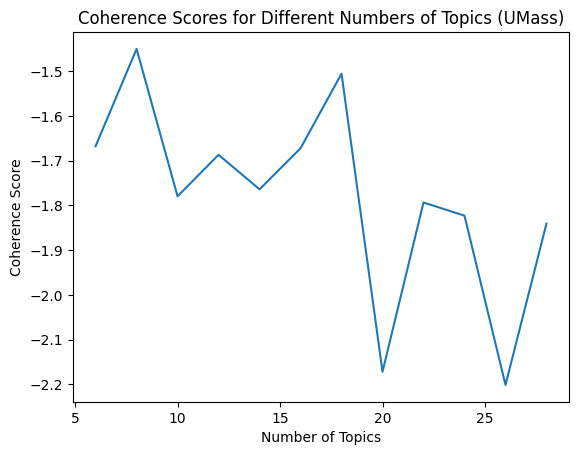

The optimal number of topics is: 8


In [6]:
# Function to compute coherence score for different number of topics, you can skip if you have alkredy defined the number of topics
def compute_coherence_values(dictionary, corpus, start, limit, step):
    coherence_values = []
    model_list = []
    for num_topics in tqdm(range(start, limit, step), desc="Calculating coherence scores"):
        model = LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary, passes=15)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, corpus=corpus, dictionary=dictionary, coherence='u_mass')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

# Start, limit, and step for the range of number of topics to try
start = 6
limit = 30
step = 2

# Compute coherence values
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, start=start, limit=limit, step=step)

# Plot coherence values to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics (UMass)")
plt.show()

# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is: {optimal_model.num_topics}")

In [13]:
# Train the LDA (Latent Dirichlet Allocation) model
lda_model = LdaModel(corpus, num_topics=8, id2word=dictionary, passes=15)
# num_topics= Number of topics to be identified by the model.
# passes=15: Number of iterations through the corpus during training.

# Assign topics to documents
def get_document_topic(bow, model):
    """
    Get the dominant topic for a given document represented as a bag-of-words.
    :param bow: Bag-of-words representation of the document.
    :param model: Trained LDA model.
    :return: Dominant topic for the document.
    """
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Apply the function to get the dominant topic for each document
df['topic'] = [get_document_topic(bow, lda_model) for bow in corpus]

# Extract the most relevant keywords for each topic
topics_keywords = lda_model.show_topics(num_topics=8, num_words=15, formatted=False)
# num_topics=20: Number of topics to be displayed.
# num_words=15: Number of keywords to display for each topic.
# formatted=False: Return the topics as lists of words instead of formatted strings.
topic_keywords_list = {topic: [word for word, prob in words] for topic, words in topics_keywords}


In [14]:
# Save the updated DataFrame to a new CSV file
df.to_csv('wos_2009_literature_review_with_topics.csv', index=False)

# Prepare the keywords data for export
keywords_data = []
for topic, keywords in topic_keywords_list.items():
    keywords_data.append({'topic': topic, 'keywords': ', '.join(keywords)})

# Create a DataFrame for the keywords
keywords_df = pd.DataFrame(keywords_data)

# Save the keywords DataFrame to a CSV file
keywords_df.to_csv('topic_keywords_2009.csv', index=False)

# Display the most relevant 15 keywords for each topic
for topic, keywords in topic_keywords_list.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# If you want to return the keywords list in a variable
topic_keywords = [{"topic": topic, "keywords": keywords} for topic, keywords in topic_keywords_list.items()]

Topic 0: price, electricity, market, model, forecast, result, wind, energy, reserve, power, capacity, cost, load, datum, study
Topic 1: electricity, market, price, energy, model, demand, power, reserve, result, production, supply, gas, fuel, analysis, increase
Topic 2: electricity, firm, market, equilibrium, power, cost, demand, price, capacity, pricing, effect, customer, result, generation, reserve
Topic 3: market, power, price, electricity, system, emission, reserve, base, model, demand, different, energy, time, spot, certificate
Topic 4: electricity, energy, market, policy, renewable, cost, industry, reserve, generation, development, reform, power, technology, sector, country
Topic 5: market, power, transmission, system, electricity, generation, cost, base, method, model, approach, investment, planning, term, present
Topic 6: market, system, model, power, propose, problem, method, price, base, transmission, reserve, electricity, unit, network, cost
Topic 7: energy, system, gas, powe

In [15]:
## Now conduct second batch 2010-14
# Load data
df = pd.read_csv('/content/sample_data/wos_201014.csv', encoding = "latin1")  # Ensure the CSV has columns 'title' and 'abstract'

In [16]:
df['processed_text'] = df['Abstract'].apply(preprocess)
# Vectorization using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# max_df=0.95: Ignore terms that appear in more than 95% of the documents.
# min_df=2: Ignore terms that appear in fewer than 2 documents.
X = vectorizer.fit_transform(df['processed_text'])

# Convert documents into a format suitable for Gensim's LDA model
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([text.split() for text in df['processed_text']])
# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]

Calculating coherence scores: 100%|██████████| 12/12 [10:18<00:00, 51.51s/it]


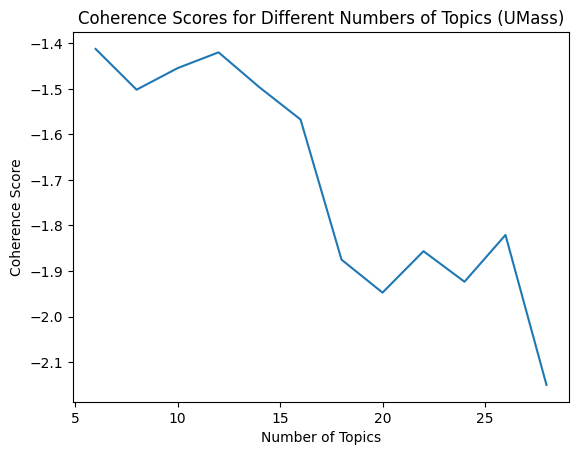

The optimal number of topics is: 6


In [17]:
# Compute coherence values and find optimal topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, start=start, limit=limit, step=step)

# Plot coherence values to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics (UMass)")
plt.show()

# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is: {optimal_model.num_topics}")

In [18]:
# Train the LDA (Latent Dirichlet Allocation) model
lda_model = LdaModel(corpus, num_topics = 12, id2word=dictionary, passes=15)
# num_topics= Number of topics to be identified by the model.
# passes=15: Number of iterations through the corpus during training.

# Assign topics to documents
def get_document_topic(bow, model):
    """
    Get the dominant topic for a given document represented as a bag-of-words.
    :param bow: Bag-of-words representation of the document.
    :param model: Trained LDA model.
    :return: Dominant topic for the document.
    """
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Apply the function to get the dominant topic for each document
df['topic'] = [get_document_topic(bow, lda_model) for bow in corpus]

# Extract the most relevant keywords for each topic
topics_keywords = lda_model.show_topics(num_topics = 12, num_words=15, formatted=False)
# num_topics=: Number of topics to be displayed.
# num_words=15: Number of keywords to display for each topic.
# formatted=False: Return the topics as lists of words instead of formatted strings.
topic_keywords_list = {topic: [word for word, prob in words] for topic, words in topics_keywords}


In [19]:
# Save the updated DataFrame to a new CSV file
df.to_csv('wos_2010_2014_literature_review_with_topics.csv', index=False)

# Prepare the keywords data for export
keywords_data = []
for topic, keywords in topic_keywords_list.items():
    keywords_data.append({'topic': topic, 'keywords': ', '.join(keywords)})

# Create a DataFrame for the keywords
keywords_df = pd.DataFrame(keywords_data)

# Save the keywords DataFrame to a CSV file
keywords_df.to_csv('topic_keywords_2010_2014.csv', index=False)

# Display the most relevant 15 keywords for each topic
for topic, keywords in topic_keywords_list.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# If you want to return the keywords list in a variable
topic_keywords = [{"topic": topic, "keywords": keywords} for topic, keywords in topic_keywords_list.items()]

Topic 0: energy, method, problem, model, approach, power, market, risk, propose, base, system, value, study, different, use
Topic 1: market, electricity, technology, cell, cost, pv, energy, reserve, solar, consumer, retail, use, change, effect, competition
Topic 2: wind, energy, power, renewable, market, electricity, policy, reserve, technology, cost, country, development, nuclear, project, farm
Topic 3: smart, grid, energy, electricity, consumption, rural, development, demand, meter, reserve, market, sector, distribute, change, pathway
Topic 4: energy, electricity, emission, renewable, cost, carbon, system, policy, production, market, increase, fuel, reserve, technology, co2
Topic 5: market, electricity, power, policy, pv, investment, system, energy, reserve, solar, generation, reform, industry, regulatory, cost
Topic 6: market, electricity, price, demand, energy, cost, system, capacity, reserve, consumer, storage, service, power, generation, response
Topic 7: market, model, propose, 

In [20]:
## Now conduct third batch 2015-19
# Load data
df = pd.read_csv('/content/sample_data/wos_201519.csv', encoding = "latin1")  # Ensure the CSV has columns 'title' and 'abstract'

In [21]:
df['processed_text'] = df['Abstract'].apply(preprocess)
# Vectorization using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# max_df=0.95: Ignore terms that appear in more than 95% of the documents.
# min_df=2: Ignore terms that appear in fewer than 2 documents.
X = vectorizer.fit_transform(df['processed_text'])

# Convert documents into a format suitable for Gensim's LDA model
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([text.split() for text in df['processed_text']])
# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]

Calculating coherence scores: 100%|██████████| 12/12 [11:51<00:00, 59.32s/it]


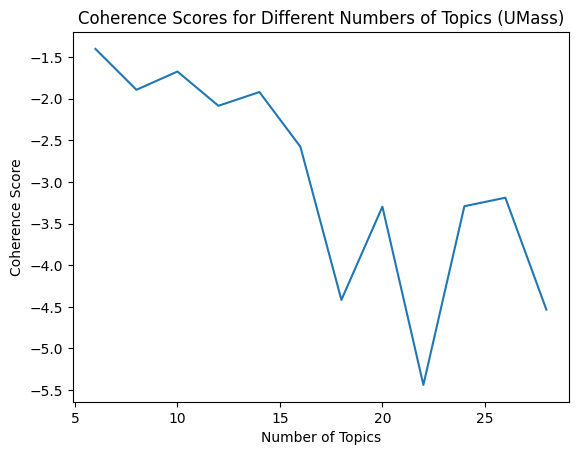

The optimal number of topics is: 6


In [22]:
# Compute coherence values and find optimal topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, start=start, limit=limit, step=step)

# Plot coherence values to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics (UMass)")
plt.show()

# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is: {optimal_model.num_topics}")

In [23]:
# Train the LDA (Latent Dirichlet Allocation) model
lda_model = LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
# num_topics= Number of topics to be identified by the model.
# passes=15: Number of iterations through the corpus during training.

# Assign topics to documents
def get_document_topic(bow, model):
    """
    Get the dominant topic for a given document represented as a bag-of-words.
    :param bow: Bag-of-words representation of the document.
    :param model: Trained LDA model.
    :return: Dominant topic for the document.
    """
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Apply the function to get the dominant topic for each document
df['topic'] = [get_document_topic(bow, lda_model) for bow in corpus]

# Extract the most relevant keywords for each topic
topics_keywords = lda_model.show_topics(num_topics = 10, num_words=15, formatted=False)
# num_topics=: Number of topics to be displayed.
# num_words=15: Number of keywords to display for each topic.
# formatted=False: Return the topics as lists of words instead of formatted strings.
topic_keywords_list = {topic: [word for word, prob in words] for topic, words in topics_keywords}


In [24]:
# Save the updated DataFrame to a new CSV file
df.to_csv('wos_2015_2019_literature_review_with_topics.csv', index=False)

# Prepare the keywords data for export
keywords_data = []
for topic, keywords in topic_keywords_list.items():
    keywords_data.append({'topic': topic, 'keywords': ', '.join(keywords)})

# Create a DataFrame for the keywords
keywords_df = pd.DataFrame(keywords_data)

# Save the keywords DataFrame to a CSV file
keywords_df.to_csv('topic_keywords_2015_2019.csv', index=False)

# Display the most relevant 15 keywords for each topic
for topic, keywords in topic_keywords_list.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# If you want to return the keywords list in a variable
topic_keywords = [{"topic": topic, "keywords": keywords} for topic, keywords in topic_keywords_list.items()]

Topic 0: energy, demand, system, grid, load, battery, market, storage, cost, model, electricity, response, electric, control, vehicle
Topic 1: energy, electricity, solar, pv, consumption, economic, technology, result, cost, study, production, efficiency, analysis, system, market
Topic 2: power, system, wind, energy, generation, reserve, market, propose, cost, model, storage, unit, renewable, plant, operation
Topic 3: gas, model, natural, forecasting, forecast, oil, hydrogen, fuel, electricity, price, coal, time, term, hybrid, performance
Topic 4: emission, carbon, heat, heating, co2, impact, environmental, reduction, trading, cycle, district, china, reduce, life, production
Topic 5: price, market, electricity, risk, effect, model, time, day, spot, volatility, wholesale, reserve, ahead, datum, b.v.
Topic 6: market, policy, electricity, power, china, industry, firm, change, sector, energy, coal, development, reform, transition, regulation
Topic 7: energy, investment, risk, market, system

In [26]:
## Now conduct fourth batch 2020-24
# Load data
df = pd.read_csv('/content/sample_data/wos_202024.csv', encoding = "latin1")  # Ensure the CSV has columns 'title' and 'abstract'

In [27]:
df['processed_text'] = df['Abstract'].apply(preprocess)
# Vectorization using TF-IDF (Term Frequency-Inverse Document Frequency)
vectorizer = TfidfVectorizer(max_df=0.95, min_df=2, stop_words='english')
# max_df=0.95: Ignore terms that appear in more than 95% of the documents.
# min_df=2: Ignore terms that appear in fewer than 2 documents.
X = vectorizer.fit_transform(df['processed_text'])

# Convert documents into a format suitable for Gensim's LDA model
# Create a dictionary representation of the documents
dictionary = corpora.Dictionary([text.split() for text in df['processed_text']])
# Create a bag-of-words representation of the documents
corpus = [dictionary.doc2bow(text.split()) for text in df['processed_text']]

Calculating coherence scores: 100%|██████████| 12/12 [09:21<00:00, 46.76s/it]


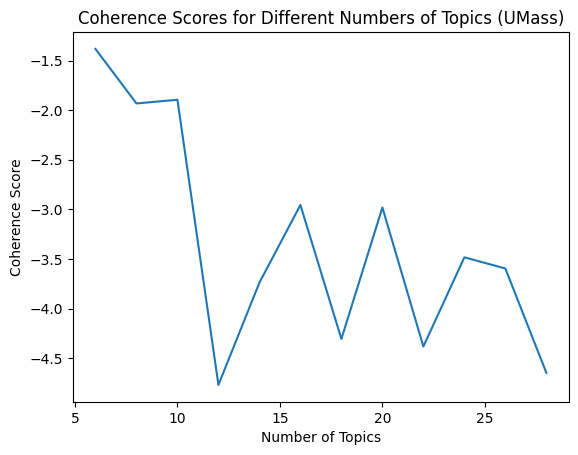

The optimal number of topics is: 6


In [28]:
# Compute coherence values and find optimal topics
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=corpus, start=start, limit=limit, step=step)

# Plot coherence values to find the optimal number of topics
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence Scores for Different Numbers of Topics (UMass)")
plt.show()

# Select the model with the highest coherence score
optimal_model = model_list[coherence_values.index(max(coherence_values))]
print(f"The optimal number of topics is: {optimal_model.num_topics}")

In [29]:
# Train the LDA (Latent Dirichlet Allocation) model
lda_model = LdaModel(corpus, num_topics = 10, id2word=dictionary, passes=15)
# num_topics= Number of topics to be identified by the model.
# passes=15: Number of iterations through the corpus during training.

# Assign topics to documents
def get_document_topic(bow, model):
    """
    Get the dominant topic for a given document represented as a bag-of-words.
    :param bow: Bag-of-words representation of the document.
    :param model: Trained LDA model.
    :return: Dominant topic for the document.
    """
    topics = model.get_document_topics(bow)
    return max(topics, key=lambda x: x[1])[0]  # Return the topic with the highest probability

# Apply the function to get the dominant topic for each document
df['topic'] = [get_document_topic(bow, lda_model) for bow in corpus]

# Extract the most relevant keywords for each topic
topics_keywords = lda_model.show_topics(num_topics = 10, num_words=15, formatted=False)
# num_topics=: Number of topics to be displayed.
# num_words=15: Number of keywords to display for each topic.
# formatted=False: Return the topics as lists of words instead of formatted strings.
topic_keywords_list = {topic: [word for word, prob in words] for topic, words in topics_keywords}

In [31]:
# Save the updated DataFrame to a new CSV file
df.to_csv('wos_2020_2024_literature_review_with_topics.csv', index=False)

# Prepare the keywords data for export
keywords_data = []
for topic, keywords in topic_keywords_list.items():
    keywords_data.append({'topic': topic, 'keywords': ', '.join(keywords)})

# Create a DataFrame for the keywords
keywords_df = pd.DataFrame(keywords_data)

# Save the keywords DataFrame to a CSV file
keywords_df.to_csv('topic_keywords_2020_2024.csv', index=False)

# Display the most relevant 15 keywords for each topic
for topic, keywords in topic_keywords_list.items():
    print(f"Topic {topic}: {', '.join(keywords)}")

# If you want to return the keywords list in a variable
topic_keywords = [{"topic": topic, "keywords": keywords} for topic, keywords in topic_keywords_list.items()]

Topic 0: battery, demand, system, dr, model, vehicle, ev, response, load, electric, flexibility, propose, cost, power, energy
Topic 1: product, waste, city, rwrp, recycling, electrical, mixture, conductivity, soil, recyclable, zero, material, increase, study, organic
Topic 2: carbon, energy, emission, renewable, impact, economic, policy, environmental, development, consumption, production, effect, study, result, analysis
Topic 3: system, propose, power, problem, method, model, frequency, time, uncertainty, reserve, consider, distribution, base, bus, optimization
Topic 4: market, price, electricity, power, model, consumer, cost, mechanism, trading, generation, energy, result, profit, renewable, demand
Topic 5: energy, policy, pv, study, solar, system, technology, country, transition, resource, analysis, find, base, low, renewable
Topic 6: oil, price, ip, volatility, sector, study, global, transmission, variable, topology, shock, spillover, fuel, crude, natural
Topic 7: energy, system, p